# The Multi Layer Perceptron

> *"Rome wasn't build in a day" - Unknown*

The MLP represents the simplest architecture that forms the basis for every other complex network architecture found today. In this notebook we are going to implement a MLP form scratch using Pytorch that recognizes handwritten digits.

## Data Loading
Every Neural Network must process some data by definition. Pytorch provides a straightforward API for data loading. To define a Dataset you just need to extend the `Dataset` class. 
Pytorch provides by default some datasets that you can use (including MNIST), but for more pedagogical value we are going to implement it from scratch

In [367]:
# Create a directory to store resources
!mkdir -p resources

# Download the training set
!curl -o resources/train-images.gz http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -o resources/train-labels.gz http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

# Download the test set
!curl -o resources/test-images.gz http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -o resources/test-labels.gz http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

# Decompress all archives
!gzip -d resources/*.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  4186k      0  0:00:02  0:00:02 --:--:-- 4186k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0^C
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  17469      0 --:--:-- --:--:-- --:--:-- 17469
gzip: resources/test-labels already exists; do you

When implementing a custom dataset we need to implement just 2 methods: `__len__` and `__getitem__`. The first one should return the total number of examples on the dataset, while the other one must return a record given its position (as an index).
In this example, since the datasets is pretty small, it's possible to load it directly into the memory. In this case, we are going to load it entirely into a one dimensional *tensor* to then change its dimensions (shape) by creating a *view* that matches the right dimensions.


`[ p1_1, ... p1_n, p2_1, ...., p2_n, ....] ` -- *view* --> `[[p1_1, .., p1_n], [p2_1, ..., p2_n], ...]`

In [335]:
from torch.utils.data import Dataset
import numpy as np

def get_uint(b: bytes) -> int:
    return int.from_bytes(b, 'big') 

# Custom dataset that loads the whole dataset into a tensor
class CustomMNIST(Dataset):

    def __init__(self, images_path: str, labels_path: str, device='cpu'):
        print('Loading the dataset...')
        with open(images_path, 'rb') as images_file:
            images_data = images_file.read()

        with open(labels_path, 'rb') as labels_file:
            labels_data = labels_file.read()
        
        # Parse the header. For more information see the Website of MNIST 
        self.dataset_size = get_uint(images_data[4:8])
        self.image_width = get_uint(images_data[8:12])
        self.image_height = get_uint(images_data[12:16])

        # Define the size of an image in bytes
        row_sz = self.image_width * self.image_height
        
        # Parse the actual data
        self.images_data = torch.frombuffer(images_data[16:], dtype=torch.uint8).float().view(-1, row_sz).to(device)
        self.labels_data = torch.frombuffer(labels_data[8:], dtype=torch.uint8).to(device)

        print(f'Loaded MNIST with {self.dataset_size} ({self.image_width}x{self.image_height}) images')

    def __len__(self) -> int:
        return self.dataset_size
        
    def __getitem__(self, idx):
        return self.images_data[idx], self.labels_data[idx] 

Let's now test if it works correcly by printing one of the images

Loading the dataset...
Loaded MNIST with 60000 (28x28) images


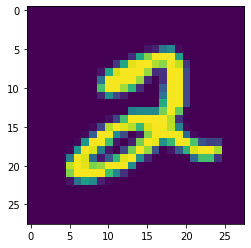

Label: 2


In [366]:
from matplotlib import pyplot as plt

training_data = CustomMNIST('resources/train-images', 'resources/train-labels')
data, label = dataset.__getitem__(5)
data = data.reshape(training_data.image_height, training_data.image_width, 1)
plt.imshow(data)
plt.show()
print(f'Label: {label}')

## Defining the Model
Every model in PyTorch is defined by creating a subclass of `nn.Module`. Each layer of the network is in turn a module, so in our case we need first to define 2 modules: the linear layer and the activation function layer. The first one is just a matrix multiplication of a weight matrix. The dimensions of such matrix can be passed as parameters. The second is just a ReLU activation, so we just zero out every negative element.
The operations that must be done by each layer are implemented inside the `forward` method, which takes as input a tensor coming from the output of the previous layer.

In [290]:
import torch
from torch import Tensor
from torch import nn
from torch.nn.parameter import Parameter
import math

class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(Linear, self).__init__()
        # Weights are initialized using a Uniform distribution bounded on -sqrt(k), where k is 1/no_features
        k = math.sqrt(1 / in_features)

        # Instead of adding plain pytorch tensors, we add them to Parameters class so that they are considered as model's parameters
        self.weights = Parameter(torch.empty(in_features, out_features).uniform_(-k, k))
        # add biases
        self.bias = Parameter(torch.rand(out_features).uniform_(-k, k))
    
    def forward(self, x: Tensor) -> Tensor:
        return x @ self.weights + self.bias

class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x: Tensor) -> Tensor:
        x[(x < 0)] = 0
        return x

As you can see, in the linear layer we just initialized a `(input_features x out_features)` matrix with elements sampled from a uniform distribution bounded at $k = \sqrt{\frac{1}{input features}}$. We then return in the forward method the matrix multiplication between the input and such weight matrix. We also add a bias.
The ReLU activation is just straightforward since we zero out just the negative elements, returning the result.

Now that we have define the layers of our network, we can implement our final model

In [291]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_features: int, hidden_units: int, out_features: int) -> None:
        super(MultiLayerPerceptron, self).__init__()
        self.stack = nn.Sequential(
            Linear(in_features, hidden_units),
            ReLU(),
            Linear(hidden_units, hidden_units),
            ReLU(),
            Linear(hidden_units, out_features),
        )
        
    def forward(self, x: Tensor) -> Tensor:
        return self.stack(x)

To execute each layer sequentially pytorch provides the `Sequential` layer. Thus our network will be simply made of 3 layers (input, hidden, output), thus forcing each input signal to propagate sequentially between each layer in order to reach the output layer.
Let's now create the model and train it.

In [356]:
# If there is a GPU, use it. Then create the model and move it to the GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultiLayerPerceptron(784, 512, 10).to(device)

## Training the Model
Machine Learning is about training models with data. We defined both the model and our data, so now it's the time to learn our model and see how it will perform on test data alone.

In [362]:
from torch.utils.data import DataLoader
import sys

# Load the datasets and wrap them into dataloaders
training_data = CustomMNIST('resources/train-images', 'resources/train-labels', device)
test_data = CustomMNIST('resources/test-images', 'resources/test-labels', device)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 10

# Define the optimizer as the Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define the training loop
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn) -> None:
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        # Do a forward pass to compute the loss with respect to the real value
        res = model(X)
        loss = loss_fn(res, y)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            sys.stdout.write(f"\rLoss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            sys.stdout.flush()
            
# Train the model
train_loop(train_dataloader, model, loss_fn)

Loading the dataset...
Loaded MNIST with 60000 (28x28) images
Loading the dataset...
Loaded MNIST with 10000 (28x28) images
Loss: 0.068564  [57600/60000]

In [365]:
# Now we are going to test the model
def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn) -> None:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.112232 

